# Processing SST1 RSoXS Data

## Pip install and restart kernel 

In [1]:
# Only needs to be run once per session, restart kernel after running

# %pip install pyhyperscattering  # to use pip published package
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory
!pip install zarr  # fixed an error with xr.DataSet.to_zarr() method, though not sure if this is really needed

Obtaining file:///nsls2/users/alevin/repos/pyhyper_toneygroup_fork/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0+untagged.473.ga637216.dirty-0.editable-py3-none-any.whl size=5538 sha256=ef4168636e18db5fae5849e0ef51e835a509b2167bc8f410d4d64a5673430ddd
  Stored in directory: /tmp/pip-ephem-wheel-cache-8wem9mrw/wheels/e0/0f/05/37d58830f3173dff95b898c129ebcad7f1ba75cc18b0a5c2d4
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0.2.1
    Uninstalling PyHyperScattering-0.2.1:
      Successfully uninstalled PyHyperScattering-0.2.1


In [8]:
# pip install --pre --upgrade tiled[all] databroker  # needed to fix tiled/databroker error in SST1RSoXSDB

## Imports

In [1]:
## The autoreload IPython magic command reloads all modules before code is ran
%load_ext autoreload

In [3]:
## Imports
import PyHyperScattering as phs
import pathlib
import sys
import json
import datetime
import dask.array as da
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib_inline.backend_inline import set_matplotlib_formats

sys.path.append('/nsls2/users/alevin/local_lib')
from andrew_rsoxs_fxns import *

## Some setup functions
set_matplotlib_formats('svg')
# c = from_profile('rsoxs')
print(f'Using PyHyperScattering Version: {phs.__version__}')
rsoxsload = phs.load.SST1RSoXSDB(corr_mode='None', use_chunked_loading=True)  # initialize rsoxs databroker loader w/ Dask

## Define masks directory path
userPath = pathlib.Path('/nsls2/users/alevin')
notebookPath = pathlib.Path.cwd()
maskPath = userPath.joinpath('masks')
jsonPath = userPath.joinpath('local_lib')
propPath = pathlib.Path('/nsls2/data/sst/proposals/2022-2/pass-309180')
# zarrPath = propPath.joinpath('zarr_datasets_nov2021')
zarrPath = propPath.joinpath('zarr_datasets_jul2022')
exportPath = propPath.joinpath('processed_data')

## Set an RSoXS colormap for later
cm = plt.cm.terrain.copy()
cm.set_bad('purple')

Using PyHyperScattering Version: 0+untagged.473.ga637216.dirty


OBJECT CACHE: Will use up to 121_499_065_958 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 121_499_065_958 bytes (15% of total physical RAM)


## Loading raw data from databroker

In [4]:
## Search for and summarize runs:
runs_sum_df = rsoxsload.summarize_run(institution='CUBLDER', plan='full_carbon_scan_nd')
runs_sum_df = runs_sum_df.set_index('scan_id')  # optional, set index to scan id
display(runs_sum_df)

Running catalog search...:   0%|          | 0/9 [00:00<?, ?it/s]

Retrieving results...:   0%|          | 0/149 [00:00<?, ?it/s]

/tmp/ipykernel_170381/404260712.py:2: UserWarning: One or more missing field(s) during this load were replaced with "N/A".  Re-run with debugWarnings=True to see details.
  runs_sum_df = rsoxsload.summarize_run(institution='CUBLDER', plan='full_carbon_scan_nd')


,start_time,cycle,institution,project,sample_name,sample_id,plan,detector,polarization,exit_status,num_Images
scan_id,,,,,,,,,,,
34427,2021-11-19 13:32:01.845104,2021-3,CUBLDER,RSoXS,Blend1,Blend1,full_carbon_scan_nd,WAXS,N/A,success,129
34428,2021-11-19 13:48:43.291398,2021-3,CUBLDER,RSoXS,Blend1,Blend1,full_carbon_scan_nd,WAXS,N/A,success,129
34429,2021-11-19 14:05:41.292620,2021-3,CUBLDER,RSoXS,Blend1,Blend1,full_carbon_scan_nd,WAXS,N/A,success,129
34430,2021-11-19 14:22:23.449621,2021-3,CUBLDER,RSoXS,Blend2,Blend2,full_carbon_scan_nd,WAXS,N/A,success,95
34431,2021-11-19 15:17:01.265667,2021-3,CUBLDER,RSoXS,Blend2,Blend2,full_carbon_scan_nd,WAXS,N/A,success,10
...,...,...,...,...,...,...,...,...,...,...,...
43234,2022-08-01 18:50:36.412093,2022-2,CUBLDER,rsoxs,andrew18,andrew18,full_carbon_scan_nd,WAXS,90,success,128
43235,2022-08-01 19:03:45.222485,2022-2,CUBLDER,rsoxs,andrew17,andrew17,full_carbon_scan_nd,WAXS,0,success,128
43236,2022-08-01 19:16:52.129164,2022-2,CUBLDER,rsoxs,andrew17,andrew17,full_carbon_scan_nd,WAXS,90,success,128


In [5]:
## Slice output dataframe for samples of interest
runs_of_interest = runs_sum_df.loc[runs_sum_df['cycle']=='2022-2'].loc[runs_sum_df['sample_id']=='andrew7']
scans = sorted(runs_of_interest.index)
display(runs_of_interest)

,start_time,cycle,institution,project,sample_name,sample_id,plan,detector,polarization,exit_status,num_Images
scan_id,,,,,,,,,,,
43149,2022-07-31 19:32:43.778932,2022-2,CUBLDER,rsoxs,andrew7,andrew7,full_carbon_scan_nd,SAXS,0,success,128
43150,2022-07-31 19:45:36.817206,2022-2,CUBLDER,rsoxs,andrew7,andrew7,full_carbon_scan_nd,SAXS,90,success,128
43202,2022-08-01 11:09:19.794441,2022-2,CUBLDER,rsoxs,andrew7,andrew7,full_carbon_scan_nd,WAXS,0,success,128
43203,2022-08-01 11:24:09.998347,2022-2,CUBLDER,rsoxs,andrew7,andrew7,full_carbon_scan_nd,WAXS,90,success,128


In [6]:
### Run this for samples without error
raw_saxs = load_stacked_pol(rsoxsload, scans[0], scans[1])
raw_waxs = load_stacked_pol(rsoxsload, scans[2], scans[3])

# ### Explicity select scan_ids:
# raw_saxs = load_stacked_pol(rsoxsload, 43157, 43158)
# raw_waxs = load_stacked_pol(rsoxsload, 43213, 43214)

raw_saxs.attrs['blend_name'] = sample_guide[raw_saxs.sample_name]
raw_waxs.attrs['blend_name'] = sample_guide[raw_waxs.sample_name]
display(raw_saxs, raw_waxs)

<xarray.DataArray 'Small Angle CCD Detector_image' (pol: 2, pix_y: 1024,
                                                    pix_x: 1026, energy: 128)>
dask.array<concatenate, shape=(2, 1024, 1026, 128), dtype=int64, chunksize=(1, 1024, 1026, 1), chunktype=numpy.ndarray>
Coordinates:
  * energy   (energy) float64 270.0 270.5 271.0 271.5 ... 335.0 340.0 345.0
    dark_id  (pol, energy) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 3.0 3.0 3.0 3.0
  * pix_x    (pix_x) int64 0 1 2 3 4 5 6 ... 1019 1020 1021 1022 1023 1024 1025
  * pix_y    (pix_y) int64 0 1 2 3 4 5 6 ... 1017 1018 1019 1020 1021 1022 1023
  * pol      (pol) float64 0.0 90.0
Attributes: (12/31)
    meas_time:             2022-07-31 19:32:43.778932
    sample_name:           andrew7
    rsoxs_config:          saxs
    beamcenter_x:          492
    beamcenter_y:          510
    sdd:                   489
    ...                    ...
    rot2:                  0
    rot3:                  0
    start:                 {'uid': '987cfc65-1aed-4f64-a426-8f6c486dbc98', 't...
    stop:                  {'run_start': '987cfc65-1aed-4f64-a426-8f6c486dbc9...
    summary:               {'uid': '987cfc65-1aed-4f64-a426-8f6c486dbc98', 's...
    blend_name:            PM6-Y7BO-CF

<xarray.DataArray 'Wide Angle CCD Detector_image' (pol: 2, pix_y: 1024,
                                                   pix_x: 1026, energy: 128)>
dask.array<concatenate, shape=(2, 1024, 1026, 128), dtype=int64, chunksize=(1, 1024, 1026, 1), chunktype=numpy.ndarray>
Coordinates:
  * energy   (energy) float64 270.0 270.5 271.0 271.5 ... 335.0 340.0 345.0
    dark_id  (energy) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
  * pix_x    (pix_x) int64 0 1 2 3 4 5 6 ... 1019 1020 1021 1022 1023 1024 1025
  * pix_y    (pix_y) int64 0 1 2 3 4 5 6 ... 1017 1018 1019 1020 1021 1022 1023
  * pol      (pol) float64 0.0 90.0
Attributes: (12/31)
    meas_time:             2022-08-01 11:09:19.794441
    sample_name:           andrew7
    rsoxs_config:          waxs
    beamcenter_x:          396.3
    beamcenter_y:          542.76
    sdd:                   38.19
    ...                    ...
    rot2:                  0
    rot3:                  0
    start:                 {'uid': '9c6eb530-6f33-4935-a170-775ae3e2cd5a', 't...
    stop:                  {'run_start': '9c6eb530-6f33-4935-a170-775ae3e2cd5...
    summary:               {'uid': '9c6eb530-6f33-4935-a170-775ae3e2cd5a', 's...
    blend_name:            PM6-Y7BO-CF

## Draw/check masks & beamcenters for transforming to q-space
### 1. Check raw images at a selected energy for all loaded scan configurations:

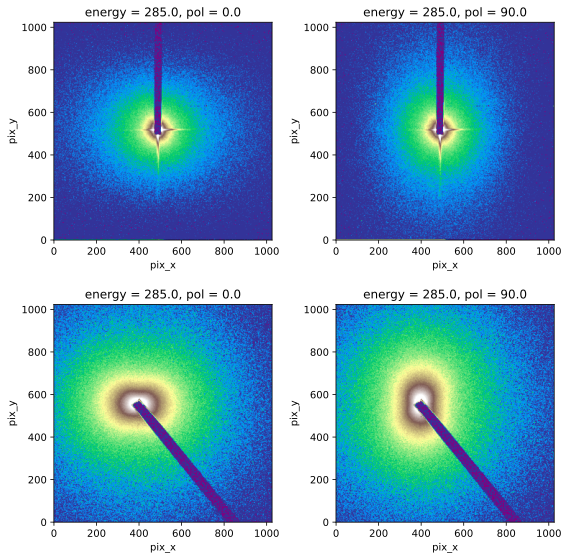

In [7]:
saxs_waxs_p00_p90_plot(raw_saxs, raw_waxs)

### 2. Draw masks

In [ ]:
# ## SAXS:
# saxs_mask_img = raw_saxs.sel(pol=0, energy=275, method='nearest').compute()
# draw = phs.IntegrationUtils.DrawMask(saxs_mask_img)
# # draw.ui()

In [ ]:
# ## Save saxs drawn mask
# draw.save(maskPath.joinpath(f'SAXS_{raw_saxs.sample_name}.json'))

In [ ]:
# ## Repeat for WAXS mask:
# waxs_mask_img = raw_waxs.sel(pol=0, energy=275, method='nearest').compute()
# draw = phs.IntegrationUtils.DrawMask(waxs_mask_img)
# # draw.ui()

In [ ]:
# ## Save and load saxs drawn mask
# draw.save(maskPath.joinpath(f'WAXS_{raw_saxs.sample_name}.json'))

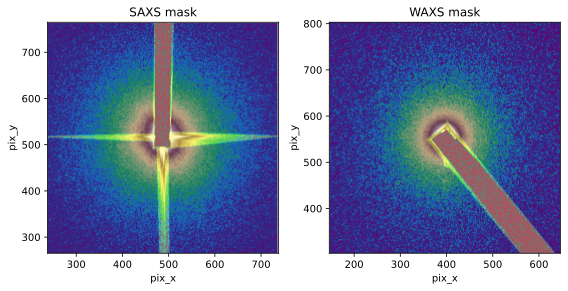

In [7]:
### Check masks on file
saxs_mask_img = raw_saxs.sel(pol=0, energy=275, method='nearest').compute()
waxs_mask_img = raw_waxs.sel(pol=0, energy=275, method='nearest').compute()
draw = phs.IntegrationUtils.DrawMask(waxs_mask_img)


### Load masks
saxs_mask, waxs_mask = plot_mask_files(draw, maskPath, raw_waxs.sample_name, saxs_img=saxs_mask_img, waxs_img=waxs_mask_img)
# plot_one_mask_file(draw, maskPath, raw_waxs.sample_name, img=raw_waxs.sel(pol=0, energy=275, method='nearest'))

### 3. Check and save beamcenters before converting to q-space

/nsls2/users/alevin/repos/pyhyper_toneygroup_fork/PyHyperScattering/src/PyHyperScattering/PFGeneralIntegrator.py:323: UserWarning: Since mask was none, creating an empty mask with shape (1024, 1026)
  self.calibrationFromTemplateXRParams(template_xr)


SAXS Beamcenter: 
poni1: 0.030899999999999997, poni2: 0.029279999999999997 
ni_beamcenter_y: 515.0, ni_beamcenter_x: 488.0


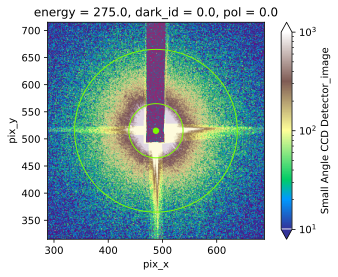

WAXS Beamcenter: 
poni1: 0.03318, poni2: 0.023777999999999997 
ni_beamcenter_y: 553.0, ni_beamcenter_x: 396.3


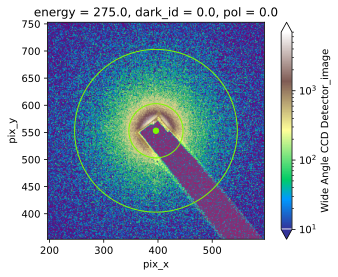

In [8]:
## SAXS
SAXSinteg = phs.integrate.PFEnergySeriesIntegrator(geomethod='template_xr', template_xr = raw_saxs.sel(pol=0))
SAXSinteg.mask = saxs_mask
SAXSinteg.ni_beamcenter_x = bcxy_2022_2['saxs_bcx']
SAXSinteg.ni_beamcenter_y = bcxy_2022_2['saxs_bcy']
raw_saxs.attrs['beamcenter_x'] = bcxy_2022_2['saxs_bcx']
raw_saxs.attrs['beamcenter_y'] = bcxy_2022_2['saxs_bcy']
raw_saxs.attrs['poni1'] = SAXSinteg.poni1
raw_saxs.attrs['poni2'] = SAXSinteg.poni2
print('SAXS Beamcenter: \n'
      f'poni1: {SAXSinteg.poni1}, poni2: {SAXSinteg.poni2} \n'
      f'ni_beamcenter_y: {SAXSinteg.ni_beamcenter_y}, ni_beamcenter_x: {SAXSinteg.ni_beamcenter_x}')

## Plot check
phs.IntegrationUtils.Check.checkAll(SAXSinteg, saxs_mask_img, img_max=1e3, alpha=0.4)
plt.xlim(SAXSinteg.ni_beamcenter_x-200, SAXSinteg.ni_beamcenter_x+200)
plt.ylim(SAXSinteg.ni_beamcenter_y-200, SAXSinteg.ni_beamcenter_y+200)
plt.gcf().set(dpi=120)
plt.show()

## WAXS
WAXSinteg = phs.integrate.PFEnergySeriesIntegrator(geomethod='template_xr', template_xr = raw_waxs.sel(pol=0))
WAXSinteg.mask = waxs_mask
WAXSinteg.ni_beamcenter_x = bcxy_2022_2['waxs_bcx']
WAXSinteg.ni_beamcenter_y = bcxy_2022_2['waxs_bcy']
raw_waxs.attrs['beamcenter_x'] = bcxy_2022_2['waxs_bcx']
raw_waxs.attrs['beamcenter_y'] = bcxy_2022_2['waxs_bcy']
raw_waxs.attrs['poni1'] = WAXSinteg.poni1
raw_waxs.attrs['poni2'] = WAXSinteg.poni2
print('WAXS Beamcenter: \n'
      f'poni1: {WAXSinteg.poni1}, poni2: {WAXSinteg.poni2} \n'
      f'ni_beamcenter_y: {WAXSinteg.ni_beamcenter_y}, ni_beamcenter_x: {WAXSinteg.ni_beamcenter_x}')

## Plot check
phs.IntegrationUtils.Check.checkAll(WAXSinteg, waxs_mask_img, img_max=7e3, alpha=0.4)
plt.xlim(WAXSinteg.ni_beamcenter_x-200, WAXSinteg.ni_beamcenter_x+200)
plt.ylim(WAXSinteg.ni_beamcenter_y-200, WAXSinteg.ni_beamcenter_y+200)
plt.gcf().set(dpi=120)
plt.show()

In [ ]:
# ## Tweaking if needed:
# ## SAXS Tweaking & Plot Check
# saxs_new_bcx = 488
# saxs_new_bcy = 515
# SAXSinteg.ni_beamcenter_x = saxs_new_bcx
# SAXSinteg.ni_beamcenter_y = saxs_new_bcy
# raw_saxs.attrs['beamcenter_x'] = saxs_new_bcx
# raw_saxs.attrs['beamcenter_y'] = saxs_new_bcy
# raw_saxs.attrs['poni1'] = SAXSinteg.poni1
# raw_saxs.attrs['poni2'] = SAXSinteg.poni2

# print('SAXS Beamcenter Tweaking: \n'
#       f'poni1: {SAXSinteg.poni1}, poni2: {SAXSinteg.poni2} \n'
#       f'ni_beamcenter_y: {SAXSinteg.ni_beamcenter_y}, ni_beamcenter_x: {SAXSinteg.ni_beamcenter_x}')

# phs.IntegrationUtils.Check.checkAll(SAXSinteg, saxs_mask_img, img_max=1e3, alpha=0.6)
# plt.xlim(SAXSinteg.ni_beamcenter_x-200, SAXSinteg.ni_beamcenter_x+200)
# plt.ylim(SAXSinteg.ni_beamcenter_y-200, SAXSinteg.ni_beamcenter_y+200)
# plt.gcf().set(dpi=120)
# plt.show()

# ## WAXS Tweaking & Plot Check
# waxs_new_bcx = 396.3
# waxs_new_bcy = 553
# WAXSinteg.ni_beamcenter_x = waxs_new_bcx
# WAXSinteg.ni_beamcenter_y = waxs_new_bcy
# raw_waxs.attrs['beamcenter_x'] = waxs_new_bcx
# raw_waxs.attrs['beamcenter_x'] = waxs_new_bcx
# raw_waxs.attrs['poni1'] = WAXSinteg.poni1
# raw_waxs.attrs['poni2'] = WAXSinteg.poni2

# print('WAXS Beamcenter Tweaking: \n'
#       f'poni1: {WAXSinteg.poni1}, poni2: {WAXSinteg.poni2} \n'
#       f'ni_beamcenter_y: {WAXSinteg.ni_beamcenter_y}, ni_beamcenter_x: {WAXSinteg.ni_beamcenter_x}')
# phs.IntegrationUtils.Check.checkAll(WAXSinteg, waxs_mask_img, img_max=5e3, alpha=0.6, guide1=40)
# plt.xlim(WAXSinteg.ni_beamcenter_x-200, WAXSinteg.ni_beamcenter_x+200)
# plt.ylim(WAXSinteg.ni_beamcenter_y-200, WAXSinteg.ni_beamcenter_y+200)
# plt.gcf().set(dpi=120)
# plt.show()


# ## Using Pete D.'s (very slightly modified) beamcentering script:
# # phs.BeamCentering.CenteringAccessor.refine_geometry

# ## SAXS
# res_saxs = raw_saxs.sel(pol=0).util.refine_geometry(energy=275, q_min=0.002, q_max=0.006)
# # res_saxs = raw_saxs.sel(pol=0).util.refine_geometry(energy=275, q_min=0.002, q_max=0.006, chi_min=-180, chi_max=60)
# # res_saxs = raw_saxs.sel(pol=0).util.refine_geometry(energy=280, q_min=0.002, q_max=0.008, mask=saxs_mask)
# raw_saxs.attrs['poni1'] = res_saxs.x[0]
# raw_saxs.attrs['poni2'] = res_saxs.x[1]
# SAXSinteg = phs.integrate.PFEnergySeriesIntegrator(geomethod='template_xr', template_xr = raw_saxs.sel(pol=0))
# SAXSinteg.mask = saxs_mask

# ## SAXS Plot check
# print('SAXS Beamcenter Post-optimization: \n'
#       f'poni1: {SAXSinteg.poni1}, poni2: {SAXSinteg.poni2} \n'
#       f'ni_beamcenter_y: {SAXSinteg.ni_beamcenter_y}, ni_beamcenter_x: {SAXSinteg.ni_beamcenter_x}')
# phs.IntegrationUtils.Check.checkAll(SAXSinteg, saxs_mask_img, img_max=1e3, alpha=0.6)
# plt.xlim(SAXSinteg.ni_beamcenter_x-200, SAXSinteg.ni_beamcenter_x+200)
# plt.ylim(SAXSinteg.ni_beamcenter_y-200, SAXSinteg.ni_beamcenter_y+200)
# plt.gcf().set(dpi=120)
# plt.show()

# ## WAXS
# # res_waxs = raw_waxs.sel(pol=0).util.refine_geometry(energy=275, q_min=0.02, q_max=0.06, chi_min=-10, chi_max=70)
# res_waxs = raw_waxs.sel(pol=0).util.refine_geometry(energy=275, q_min=0.02, q_max=0.06)
# raw_waxs.attrs['poni1'] = res_waxs.x[0]
# raw_waxs.attrs['poni2'] = res_waxs.x[1]
# WAXSinteg = phs.integrate.PFEnergySeriesIntegrator(geomethod='template_xr', template_xr = raw_waxs.sel(pol=0))
# WAXSinteg.mask = waxs_mask

# ## WAXS Plot check
# print('WAXS Beamcenter Post-optimization: \n'
#       f'poni1: {WAXSinteg.poni1}, poni2: {WAXSinteg.poni2} \n'
#       f'ni_beamcenter_y: {WAXSinteg.ni_beamcenter_y}, ni_beamcenter_x: {WAXSinteg.ni_beamcenter_x}')
# phs.IntegrationUtils.Check.checkAll(WAXSinteg, waxs_mask_img, img_max=5e3, alpha=0.6)
# plt.xlim(WAXSinteg.ni_beamcenter_x-200, WAXSinteg.ni_beamcenter_x+200)
# plt.ylim(WAXSinteg.ni_beamcenter_y-200, WAXSinteg.ni_beamcenter_y+200)
# plt.gcf().set(dpi=120)
# plt.show()

In [16]:
### Write beamcenters to saved .json file if content with them:

beamcenters_dict = {
    f'SAXS_{raw_saxs.sample_name}': {'bcx':raw_saxs.beamcenter_x, 'bcy':raw_saxs.beamcenter_y},
    f'WAXS_{raw_waxs.sample_name}': {'bcx':raw_waxs.beamcenter_x, 'bcy':raw_waxs.beamcenter_y}
}

with open(jsonPath.joinpath('beamcenters_dict.json'), 'r') as f:
    dic = json.load(f)

dic.update(beamcenters_dict)

with open(jsonPath.joinpath('beamcenters_dict.json'), 'w') as f:
    json.dump(dic, f)

## Export data
These files are large and therefore should not be saved into the user folder, but rather the proposal folder:


### 1. Apply qx,qy labels, save .zarr stores

In [12]:
### Now that we know our beamcenters are accurate, we can apply correct q axis labels
raw_waxs = apply_q_labels(raw_waxs)
raw_saxs = apply_q_labels(raw_saxs)

### Load energy lists for facet plots
energies = raw_waxs.energy.data
resonant_energies = energies[16:96]

gif_energies = np.array([])
gif_energies = np.append(energies[0:16:3], energies[-31::2])
gif_energies = np.sort(np.append(gif_energies, resonant_energies))

### Set variables for naming purposes
sample_name = sample_guide[raw_waxs.sample_name]
detector = detector_guide[raw_waxs.detector]

# sampPath = exportPath.joinpath(f'{detector}_{sample_name}')
# sampPath.mkdir(parents=True, exist_ok=True)

In [10]:
# sorted([f.name for f in zarrPath.iterdir()])

In [13]:
### Save zarr store/directory 

save_zarr((raw_saxs, raw_waxs), zarrPath)

In [ ]:
# ### Generate WAXS facet plots
# sample_name = sample_guide[raw_waxs.sample_name]
# scan_id = raw_waxs.sampleid
# detector = detector_guide[raw_waxs.detector]

# scanPath = facetPath.joinpath(f'{scan_id}_{sample_name}_{detector}')
# scanPath.mkdir(parents=True, exist_ok=True)

# for pol in (0, 90):
#     for num in range(10):
#         grid = raw_waxs.sel(pol=pol, energy=energy_list[8*num:8*num+8], method='nearest').plot.imshow(x='qx', y='qy',
#                     norm=LogNorm(1e1, 5e3), cmap=cm, interpolation='antialiased', col='energy', col_wrap=4)
#         grid.set_xlabels('qx [1/Å]')
#         grid.set_ylabels('qy [1/Å]') 

#         # Create/select folder for scan to save plots:
#         imgsPath = scanPath.joinpath(f'_qxqy_frames_{detector}_{int(pol):0>2}deg')
#         imgsPath.mkdir(parents=True, exist_ok=True)

#         plt.savefig(imgsPath.joinpath(f'{sample_name}_{detector}_{int(pol):0>2}_f{num}.svg'))

### 2. Convert to chi-q space & save .zarr stores

In [14]:
integ_saxs = integrate_stacked_pol(SAXSinteg, raw_saxs)
integ_waxs = integrate_stacked_pol(WAXSinteg, raw_waxs)
display(integ_saxs, integ_waxs)

chunking on energy
chunking on energy
chunking on energy
chunking on energy


,Array,Chunk
Bytes,351.56 MiB,6.87 MiB
Shape,"(2, 128, 360, 500)","(1, 5, 360, 500)"
Count,1063 Graph Layers,52 Chunks
Type,float64,numpy.ndarray


,Array,Chunk
Bytes,351.56 MiB,6.87 MiB
Shape,"(2, 128, 360, 500)","(1, 5, 360, 500)"
Count,1067 Graph Layers,52 Chunks
Type,float64,numpy.ndarray


In [15]:
### Save zarr store/directory 
save_zarr((integ_saxs, integ_waxs), zarrPath, prefix='integ_qchi')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
sorted(zarrPath.glob('raw*w18*SAXS*'))

In [ ]:
### How you would load data:
loaded_raw_saxs = xr.open_zarr(sorted(zarrPath.glob('raw*w11*SAXS*'))[0]).saxs
loaded_raw_waxs = xr.open_zarr(sorted(zarrPath.glob('raw*w11*WAXS*'))[0]).waxs
loaded_integ_saxs = xr.open_zarr(sorted(zarrPath.glob('integ*w11*SAXS*'))[0]).saxs
loaded_integ_waxs = xr.open_zarr(sorted(zarrPath.glob('integ*w11*WAXS*'))[0]).waxs

In [ ]:
### Load energy lists for facet plots
energies = raw_waxs.energy.data
resonant_energies = energies[16:96]

gif_energies = np.array([])
gif_energies = np.append(energies[0:16:3], energies[-31::2])
gif_energies = np.sort(np.append(gif_energies, resonant_energies))

pol=0

# #### View facet plot to verify data:
# loaded_integ_waxs.sel(pol=pol, energy=gif_energies[:-6:6], method='nearest').plot.imshow(xscale='log', xlim=(1e-2, 2e-1),
#                         norm=LogNorm(1e1, 5e3), cmap=cm, interpolation='antialiased', col='energy', col_wrap=4)
# loaded_integ_saxs.sel(pol=pol, energy=gif_energies[:-6:6], method='nearest').plot.imshow(xscale='log', xlim=(1e-3, 1e-2),
#                         norm=LogNorm(1e1, 5e3), cmap=cm, interpolation='antialiased', col='energy', col_wrap=4)
